# Import Trained Network

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers

!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
  
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

from tensorflow.keras.applications.inception_v3 import InceptionV3

pre_trained_model = InceptionV3(
    input_shape = (150, 150, 3),
    include_top = False,
    weights = None
)

for layer in pre_trained_model.layers:
  layer.trainable = False

pre_trained_model.load_weights(local_weights_file)  
pre_trained_model.summary()  
  
last_layer = pre_trained_model.get_layer('mixed7')
print(last_layer.output_shape)
last_output = last_layer.output



--2019-07-12 11:57:49--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.141.128, 2607:f8b0:400c:c06::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.141.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   141MB/s    in 0.6s    

2019-07-12 11:57:50 (141 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                               

# Import Data

In [6]:
!wget --no-check-certificate \
        https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
       -O /tmp/cats_and_dogs_filtered.zip

import zipfile

local_file = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_file, 'r')
zip_ref.extractall('/tmp/cats_and_dogs_filtered')
zip_ref.close()

print("Number of training samples (cat): ", len(os.listdir('/tmp/cats_and_dogs_filtered/cats_and_dogs_filtered/train/cats')))
print("Number of training samples (dog): ", len(os.listdir('/tmp/cats_and_dogs_filtered/cats_and_dogs_filtered/train/dogs')))
print("Number of validation samples (cat): ", len(os.listdir('/tmp/cats_and_dogs_filtered/cats_and_dogs_filtered/validation/cats')))
print("Number of validation samples (dog): ", len(os.listdir('/tmp/cats_and_dogs_filtered/cats_and_dogs_filtered/validation/dogs')))

Number of training samples (cat):  1000
Number of training samples (dog):  1000
Number of validation samples (cat):  500
Number of validation samples (dog):  500


# Model Definition

In [0]:
x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation = 'sigmoid')(x)

model = Model(pre_trained_model.input, x)

from tensorflow.keras.optimizers import RMSprop

model.compile(
    loss = 'binary_crossentropy',
    optimizer = RMSprop(lr = 1e-3),
    metrics = ['accuracy']
)

In [11]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
____________________________________________________________________________________________

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = '/tmp/cats_and_dogs_filtered/cats_and_dogs_filtered/train'
validation_dir = '/tmp/cats_and_dogs_filtered/cats_and_dogs_filtered/validation'

train_datagen = ImageDataGenerator(
    rescale = 1. / 255.0,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    shear_range =0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

validation_datagen = ImageDataGenerator(
    rescale = 1. /255.0
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size = 20,
    target_size = (150, 150),
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    batch_size = 20,
    target_size = (150, 150),
    class_mode = 'binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [18]:
history = model.fit_generator(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 100,
    validation_steps = 50,
    epochs = 20,
    verbose = 1
)

Epoch 1/20
100/100 [==============================] - 289s 3s/step - loss: 1.0045 - acc: 0.7573 - val_loss: 0.6268 - val_acc: 0.8655
Epoch 2/20
100/100 [==============================] - 283s 3s/step - loss: 0.3992 - acc: 0.8286 - val_loss: 0.8687 - val_acc: 0.8712
Epoch 3/20
100/100 [==============================] - 284s 3s/step - loss: 0.3608 - acc: 0.8486 - val_loss: 0.6156 - val_acc: 0.9118
Epoch 4/20
100/100 [==============================] - 285s 3s/step - loss: 0.3324 - acc: 0.8646 - val_loss: 0.3151 - val_acc: 0.9511
Epoch 5/20
100/100 [==============================] - 285s 3s/step - loss: 0.3131 - acc: 0.8715 - val_loss: 0.6128 - val_acc: 0.9213
Epoch 6/20
100/100 [==============================] - 290s 3s/step - loss: 0.2868 - acc: 0.8860 - val_loss: 0.8848 - val_acc: 0.9023
Epoch 7/20
100/100 [==============================] - 287s 3s/step - loss: 0.2935 - acc: 0.8819 - val_loss: 0.7649 - val_acc: 0.9156
Epoch 8/20
100/100 [==============================] - 283s 3s/step - 

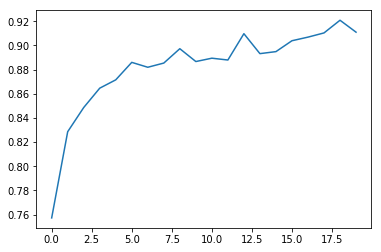

In [20]:
accuracy = history.history['acc']
epochs = history.epoch

import matplotlib.pyplot as plt
plt.plot(epochs, accuracy)